## Modules & Functions

In [0]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl
import h5py,urllib,zipfile,tensorflow_hub as th
import tensorflow as tf
import skimage.transform as st
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Dropout
from keras.layers import Flatten,Input,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [0]:
fpath2='https://olgabelitskaya.github.io/'
fw='weights.syn.hdf5'
def img_rotate(image,size):
        angle=np.random.randint(-15,15)
        img=st.rotate(image,angle,resize=True)
        img=st.resize(img,(size,size))
        return np.array(img*255,dtype=np.uint8)
def label5symbols(label,symbol):
    length=len(label)
    if length>=5:
        return label
    else:
        no_labels=np.full((5-length),symbol)
        res=np.concatenate((no_labels,label),axis=0)
        return np.array(res,dtype=np.uint8)
def concat5symbols(i,rx,y,size,symbol):
    k=np.random.randint(1,6)
    img=rx[i]; label=y[i]
    for j in range(1,k):
        img=np.concatenate((img,rx[i+j]),axis=1)
        label=np.concatenate((label,y[i+j]),axis=0)
    if k!=5:
        w1=np.random.randint(0,size*5-img.shape[1])
        w2=size*5-img.shape[1]-w1        
        img=np.concatenate((np.zeros((size,w1)),img,
                            np.zeros((size,w2))),axis=1)
    img=np.array(img,dtype=np.uint8)
    label=label5symbols(label,symbol)
    return [img,label,k]

## Synthetic Data #1

In [18]:
(x_train1,y_train1),(x_test1,y_test1)=\
tf.keras.datasets.mnist.load_data()
y_train1=y_train1.reshape(-1,1)
y_test1=y_test1.reshape(-1,1)
pd.DataFrame([[x_train1.shape,x_test1.shape,x_train1.dtype],
              [y_train1.shape,y_test1.shape,y_train1.dtype]],
             columns=['train','test','dtype'],
             index=['images','labels'])

,train,test,dtype
images,"(60000, 28, 28)","(10000, 28, 28)",uint8
labels,"(60000, 1)","(10000, 1)",uint8


In [0]:
rx_train1=np.array([img_rotate(x_train1[i],28)
                    for i in range(x_train1.shape[0])])
rx_test1=np.array([img_rotate(x_test1[i],28)
                   for i in range(x_test1.shape[0])])

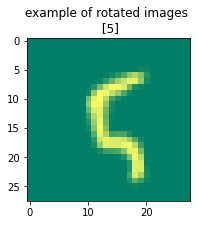

In [20]:
pl.figure(figsize=(3,3))
pl.imshow(rx_train1[100],cmap=pl.cm.summer)
pl.title('example of rotated images \n %s'%y_train1[100]);

In [21]:
sx_train1=np.empty([rx_train1.shape[0],28,140])
sy_train1=np.empty([y_train1.shape[0],5])
i=0; c=0
while i<rx_train1.shape[0]-5:
    [image,label,k]=\
    concat5symbols(i,rx_train1,y_train1,28,10)
    sx_train1[c]=image; sy_train1[c]=label
    c+=1; i+=k
sx_train1=np.array(sx_train1[:c],dtype=np.uint8)
sy_train1=np.array(sy_train1[:c],dtype=np.uint8)
[sx_train1.shape,sy_train1.shape]

[(19963, 28, 140), (19963, 5)]

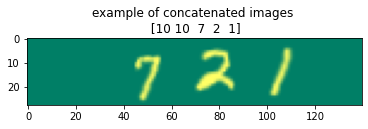

In [22]:
pl.imshow(sx_train1[100],cmap=pl.cm.summer);
pl.title('example of concatenated images \n %s'%\
         sy_train1[100]);

In [23]:
sx_test1=np.empty([rx_test1.shape[0],28,140])
sy_test1=np.empty([y_test1.shape[0],5])
i=0; c=0
while i<rx_test1.shape[0]-5:
    [image,label,k]=\
    concat5symbols(i,rx_test1,y_test1,28,10)
    sx_test1[c]=image; sy_test1[c]=label
    c+=1; i+=k
sx_test1=np.array(sx_test1[:c],dtype=np.uint8)
sy_test1=np.array(sy_test1[:c],dtype=np.uint8)
[sx_test1.shape,sy_test1.shape]

[(3367, 28, 140), (3367, 5)]

In [24]:
sx_train1=sx_train1.reshape(-1,28,28*5,1)
sx_test1=sx_test1.reshape(-1,28,28*5,1)
n=int(len(sx_test1)/2)
sx_valid1,sy_valid1=sx_test1[:n],sy_test1[:n]
sx_test1,sy_test1=sx_test1[n:],sy_test1[n:]
sy_train1_list=[sy_train1[:,i] for i in range(5)]
sy_valid1_list=[sy_valid1[:,i] for i in range(5)]
sy_test1_list=[sy_test1[:,i] for i in range(5)]
print('Reshape the train set for models')
print(sx_train1.shape,sy_train1_list[0].shape)

Reshape the train set for models
(19963, 28, 140, 1) (19963,)


## Synthetic Data #2

In [25]:
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath2+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys())
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
images=np.array(f[keys[1]])/255
images=.7-np.dot(images[...,:3],[.299,.587,.114])**2
images=np.array(images*255,dtype=np.uint8)
labels=np.array(f[keys[2]],dtype=np.uint8).reshape(-1,1)-1
x_train2,x_test2,y_train2,y_test2=\
train_test_split(images,labels,test_size=.2,random_state=1)
pd.DataFrame([[x_train2.shape,x_test2.shape,x_train2.dtype],
              [y_train2.shape,y_test2.shape,y_train2.dtype]],
             columns=['train','test','dtype'],
             index=['images','labels'])

,train,test,dtype
images,"(11352, 32, 32)","(2838, 32, 32)",uint8
labels,"(11352, 1)","(2838, 1)",uint8


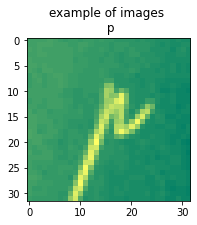

In [26]:
pl.figure(figsize=(3,3))
pl.imshow(x_train2[100],cmap=pl.cm.summer)
pl.title('example of images \n %s'%\
         letters[y_train2[100][0]]);

In [27]:
sx_train2=np.empty([x_train2.shape[0],32,160])
sy_train2=np.empty([y_train2.shape[0],5])
i=0; c=0
while i<x_train2.shape[0]-5:
    [image,label,k]=\
    concat5symbols(i,x_train2,y_train2,32,33)
    sx_train2[c]=image; sy_train2[c]=label
    c+=1; i+=k
sx_train2=np.array(sx_train2[:c],dtype=np.uint8)
sy_train2=np.array(sy_train2[:c],dtype=np.uint8)
[sx_train2.shape,sy_train2.shape]

[(3750, 32, 160), (3750, 5)]

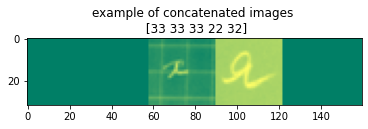

In [28]:
pl.imshow(sx_train2[100],cmap=pl.cm.summer);
pl.title('example of concatenated images \n %s'%\
         sy_train2[100]);

In [29]:
sx_test2=np.empty([x_test2.shape[0],32,160])
sy_test2=np.empty([y_test2.shape[0],5])
i=0; c=0
while i<x_test2.shape[0]-5:
    [image,label,k]=\
    concat5symbols(i,x_test2,y_test2,32,33)
    sx_test2[c]=image; sy_test2[c]=label
    c+=1; i+=k
sx_test2=np.array(sx_test2[:c],dtype=np.uint8)
sy_test2=np.array(sy_test2[:c],dtype=np.uint8)
[sx_test2.shape,sy_test2.shape]

[(933, 32, 160), (933, 5)]

In [30]:
sx_train2=sx_train2.reshape(-1,32,32*5,1)
sx_test2=sx_test2.reshape(-1,32,32*5,1)
n=int(len(sx_test2)/2)
sx_valid2,sy_valid2=sx_test2[:n],sy_test2[:n]
sx_test2,sy_test2=sx_test2[n:],sy_test2[n:]
sy_train2_list=[sy_train2[:,i] for i in range(5)]
sy_valid2_list=[sy_valid2[:,i] for i in range(5)]
sy_test2_list=[sy_test2[:,i] for i in range(5)]
print('Reshape the train set for models')
print(sx_train2.shape,sy_train2_list[0].shape)

Reshape the train set for models
(3750, 32, 160, 1) (3750,)


## CNN
### Synthetic Data #1

In [0]:
def syn_model1(size,n):    
    model_input=Input(shape=(size,size*5,1))
    x=Conv2D(32,(5,5),activation='relu',
             padding='same')(model_input)
    x=MaxPooling2D(pool_size=(2,2))(x)     
    x=Conv2D(32,(5,5),activation='relu',
             padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)
    x=BatchNormalization()(x)
    x=Conv2D(196,(5,5),activation='relu',
             padding='same')(x) 
    x=MaxPooling2D(pool_size=(2,2))(x) 
    x=Dropout(.25)(x)    
    x=Conv2D(196,(5,5),activation='relu',
             padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x) 
    x=Dropout(.25)(x)              
    x=Flatten()(x)    
    x=Dense(512,activation='relu')(x)    
    x=Dropout(.25)(x)    
    y=[Dense(n,activation='softmax')(x)
       for i in range(5)]
    model=Model(input=model_input,output=y)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model

In [32]:
syn_model1=syn_model1(28,11)
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,
                             save_best_only=True)
syn_model1.fit(sx_train1,sy_train1_list, 
               validation_data=(sx_valid1,sy_valid1_list), 
               epochs=20,batch_size=128,verbose=2,
               callbacks=[checkpointer])

Train on 19963 samples, validate on 1683 samples
Epoch 1/20
 - 21s - loss: 7.0489 - dense_2_loss: 0.5272 - dense_3_loss: 0.9686 - dense_4_loss: 1.4166 - dense_5_loss: 1.8899 - dense_6_loss: 2.2462 - dense_2_accuracy: 0.8306 - dense_3_accuracy: 0.6620 - dense_4_accuracy: 0.5012 - dense_5_accuracy: 0.3335 - dense_6_accuracy: 0.1868 - val_loss: 4.5458 - val_dense_2_loss: 0.2684 - val_dense_3_loss: 0.5550 - val_dense_4_loss: 0.9812 - val_dense_5_loss: 1.2921 - val_dense_6_loss: 1.4179 - val_dense_2_accuracy: 0.9186 - val_dense_3_accuracy: 0.8200 - val_dense_4_accuracy: 0.6548 - val_dense_5_accuracy: 0.5502 - val_dense_6_accuracy: 0.5324

Epoch 00001: val_loss improved from inf to 4.54576, saving model to weights.syn.hdf5
Epoch 2/20
 - 13s - loss: 3.1885 - dense_2_loss: 0.2013 - dense_3_loss: 0.4441 - dense_4_loss: 0.6907 - dense_5_loss: 0.9187 - dense_6_loss: 0.9334 - dense_2_accuracy: 0.9313 - dense_3_accuracy: 0.8503 - dense_4_accuracy: 0.7632 - dense_5_accuracy: 0.6827 - dense_6_accurac

In [33]:
syn_model1.load_weights(fw)
syn_scores1=syn_model1.evaluate(sx_test1,sy_test1_list,verbose=0)
print("Scores: \n" ,(syn_scores1))
print("First digit. Accuracy: %.2f%%"%(syn_scores1[6]*100))
print("Second digit. Accuracy: %.2f%%"%(syn_scores1[7]*100))
print("Third digit. Accuracy: %.2f%%"%(syn_scores1[8]*100))
print("Fourth digit. Accuracy: %.2f%%"%(syn_scores1[9]*100))
print("Fifth digit. Accuracy: %.2f%%"%(syn_scores1[10]*100))
avg_accuracy1=sum([syn_scores1[i] for i in range(6,11)])/5
print("Synthetic MNIST. Average Accuracy: %.2f%%"%(avg_accuracy1*100))

Scores: 
 [0.059910666439770735, 0.0003134107682853937, 0.006683103274554014, 0.0050345659255981445, 0.021013502031564713, 0.026464100927114487, 1.0, 0.9970308542251587, 0.9988123774528503, 0.9946556091308594, 0.9928740859031677]
First digit. Accuracy: 100.00%
Second digit. Accuracy: 99.70%
Third digit. Accuracy: 99.88%
Fourth digit. Accuracy: 99.47%
Fifth digit. Accuracy: 99.29%
Synthetic MNIST. Average Accuracy: 99.67%


## Synthetic Data #2

In [0]:
def syn_model2(size,n):    
    model_input=Input(shape=(size,size*5,1))
    x=BatchNormalization()(model_input)        
    x=Conv2D(32,(5,5),activation='relu',
             padding='same')(model_input)
    x=MaxPooling2D(pool_size=(2,2))(x)     
    x=Conv2D(32,(5,5),activation='relu',
             padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)
    x=BatchNormalization()(x)
    x=Conv2D(196,(5,5),activation='relu',
             padding='same')(x) 
    x=MaxPooling2D(pool_size=(2,2))(x) 
    x=Dropout(.25)(x)    
    x=Conv2D(196,(5,5),activation='relu',
             padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x) 
    x=Dropout(.25)(x)              
    x=Flatten()(x)    
    x=Dense(1024,activation='relu')(x)    
    x=Dropout(.25)(x)    
    y=[Dense(n,activation='softmax')(x)
       for i in range(5)]
    model=Model(input=model_input,output=y)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model

In [45]:
syn_model2=syn_model2(32,34)
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
syn_model2.fit(sx_train2,sy_train2_list, 
               validation_data=(sx_valid2,sy_valid2_list), 
               epochs=100,batch_size=128,verbose=2,
               callbacks=[checkpointer,lr_reduction,estopping])

Train on 3750 samples, validate on 466 samples
Epoch 1/100
 - 5s - loss: 13.2108 - dense_26_loss: 1.1742 - dense_27_loss: 2.0571 - dense_28_loss: 2.7575 - dense_29_loss: 3.4358 - dense_30_loss: 3.7815 - dense_26_accuracy: 0.7720 - dense_27_accuracy: 0.5701 - dense_28_accuracy: 0.3485 - dense_29_accuracy: 0.1525 - dense_30_accuracy: 0.0285 - val_loss: 12.6687 - val_dense_26_loss: 1.1658 - val_dense_27_loss: 2.0641 - val_dense_28_loss: 2.6824 - val_dense_29_loss: 3.2047 - val_dense_30_loss: 3.5194 - val_dense_26_accuracy: 0.7983 - val_dense_27_accuracy: 0.6202 - val_dense_28_accuracy: 0.4485 - val_dense_29_accuracy: 0.2232 - val_dense_30_accuracy: 0.0258

Epoch 00001: val_loss improved from inf to 12.66874, saving model to weights.syn.hdf5
Epoch 2/100
 - 3s - loss: 11.1585 - dense_26_loss: 0.7479 - dense_27_loss: 1.5274 - dense_28_loss: 2.2755 - dense_29_loss: 3.0033 - dense_30_loss: 3.6116 - dense_26_accuracy: 0.8003 - dense_27_accuracy: 0.5973 - dense_28_accuracy: 0.4019 - dense_29_acc

In [46]:
syn_model2.load_weights(fw)
syn_scores2=syn_model2.evaluate(sx_test2,sy_test2_list,verbose=0)
print("Scores: \n" ,(syn_scores2))
print("First letter. Accuracy: %.2f%%"%(syn_scores2[6]*100))
print("Second letter. Accuracy: %.2f%%"%(syn_scores2[7]*100))
print("Third letter. Accuracy: %.2f%%"%(syn_scores2[8]*100))
print("Fourth letter. Accuracy: %.2f%%"%(syn_scores2[9]*100))
print("Fifth letter. Accuracy: %.2f%%"%(syn_scores2[10]*100))
avg_accuracy2=sum([syn_scores2[i] for i in range(6,11)])/5
print("Synthetic Letters. Average Accuracy: %.2f%%"%(avg_accuracy2*100))

Scores: 
 [11.006784290011485, 0.8563066124916077, 1.5509358644485474, 2.257935047149658, 2.9001004695892334, 3.51633882522583, 0.7751606106758118, 0.5888651013374329, 0.3854389786720276, 0.20770877599716187, 0.0471092090010643]
First letter. Accuracy: 77.52%
Second letter. Accuracy: 58.89%
Third letter. Accuracy: 38.54%
Fourth letter. Accuracy: 20.77%
Fifth letter. Accuracy: 4.71%
Synthetic Letters. Average Accuracy: 40.09%
